# Notebook to test and illustrate py_cwt_2d: MORLET

Real parts reconstruction seems to add up negative, so images are [-1,0] not [0,1]

In [1]:
# if necessary install from pip
#!pip install git+https://github.com/LeonArcher/py_cwt2d

In [2]:
import numpy as np
import pywt
import py_cwt2d
from matplotlib import pyplot as plt

# Read image, do cwt_2d

In [3]:
# get an image and normalize its brightness from 0 to 1
image = pywt.data.camera()
image = (image - image.min()) / (image.max() - image.min())

# set up a range of scales in logarithmic spacing between 1 and 256 (image width / 2 seems to work here)
ss = np.geomspace(1.0,256.0,100)

# calculate the complex pycwt, and make the wavelet normalization factor CC
coeffs, wav_norm = py_cwt2d.cwt_2d(image, ss, 'morlet')

# normalization factor for each contribution in reconstruction 
CC = 1.0 / (ss * wav_norm) 

# Reconstruct with cumulatively more detail

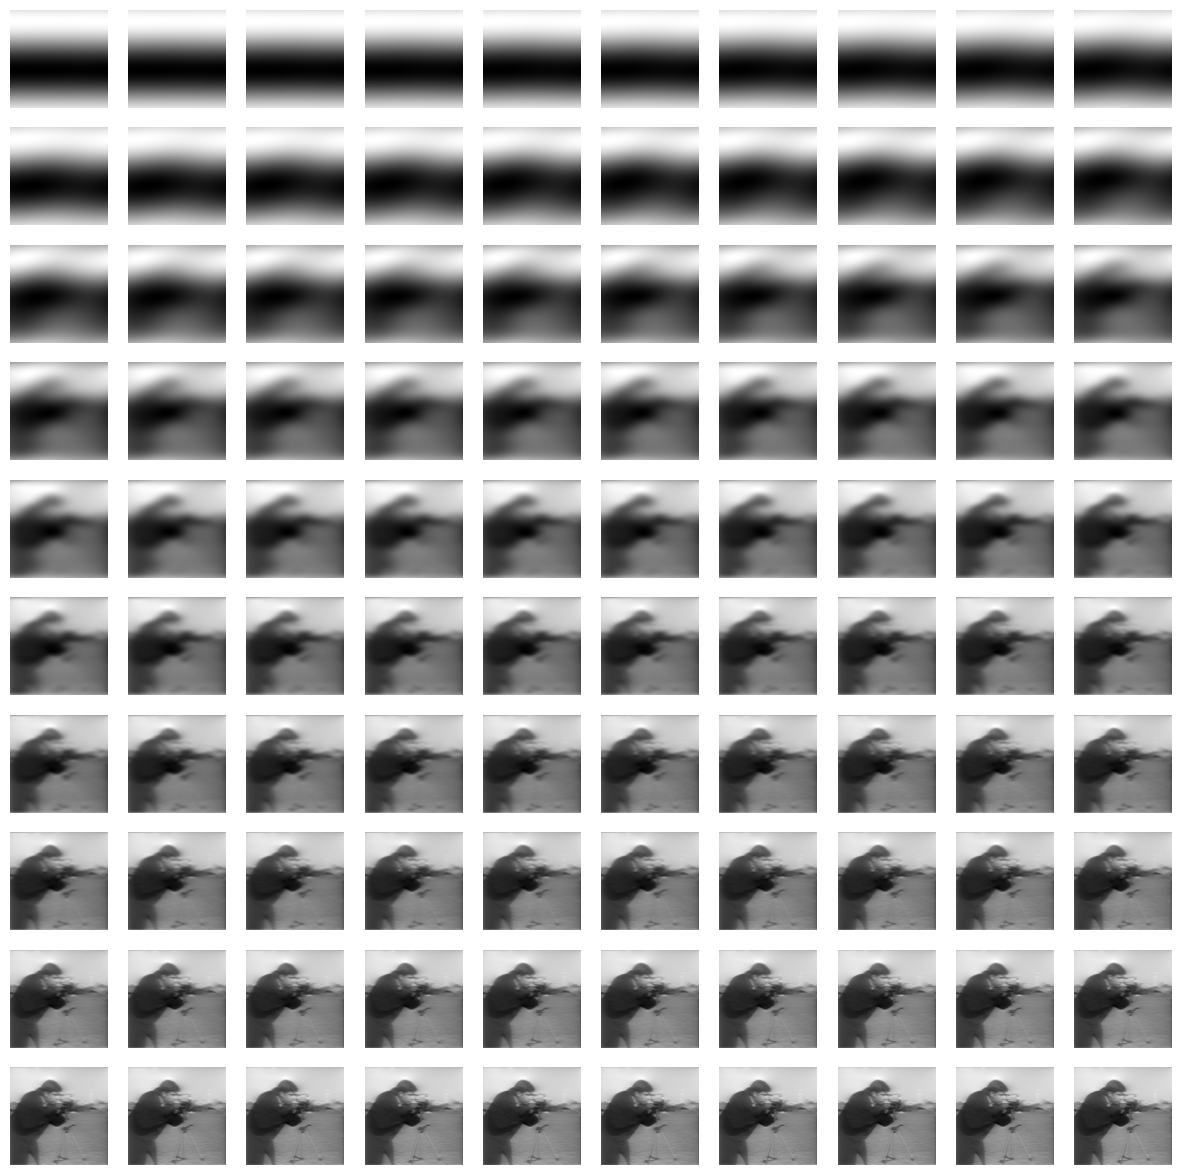

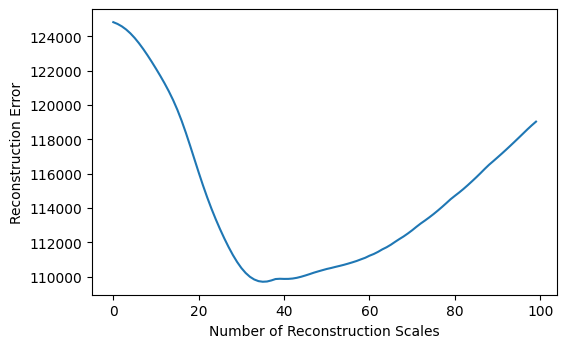

In [4]:
# Show a cumulative reconstruction with truncation level 
errors = [] # container to hold the errors by truncation level 

N = 10  # 10x10 thumbnails, since ss was defined to include 100 scales 

# Plot a successive reconstruction by truncation level
# LARGE TO SMALL scales, reversed(range())

fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))

for level in reversed( range(len(ss)) ):
    i = level // N
    j = level % N

# Prepare each thumbnail's area and disable ticks & labels 
    plt.sca(axes[N-1-i, N-1-j]); plt.axis('off')

# Weighted sum is a reconstruction to this truncation level 
    C = CC[level:]
    reconstruction = (C * np.real(coeffs[..., level:])).sum(axis=-1)

# rescale reconstruction to [0,1 range]
# needed since wavelets x scales are not orthogonal
    reconstruction = 1.0 - (reconstruction - reconstruction.min())/ \
                     (reconstruction.max() - reconstruction.min() + 1e-6) # 1e9 prevents /0 error 

# Measure error: fancy power or plain MAE
#    errors.append(np.sqrt(np.sum(np.power(reconstruction - image, 2.0))))
    errors.append(np.mean(np.sum(np.abs(reconstruction - image))))

# Thumbnail image: same [0,1] range in each because of rescaling 
    plt.imshow(-reconstruction, cmap='gray', vmin=-1, vmax=0)
    
plt.show()

# Second plot: errors as a function of truncation level 
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6/1.618))
plt.plot(errors)
plt.xlabel('Number of Reconstruction Scales')
plt.ylabel('Reconstruction Error')
plt.show()

# It is a little blurry or incomplete, for the 100 scales selected

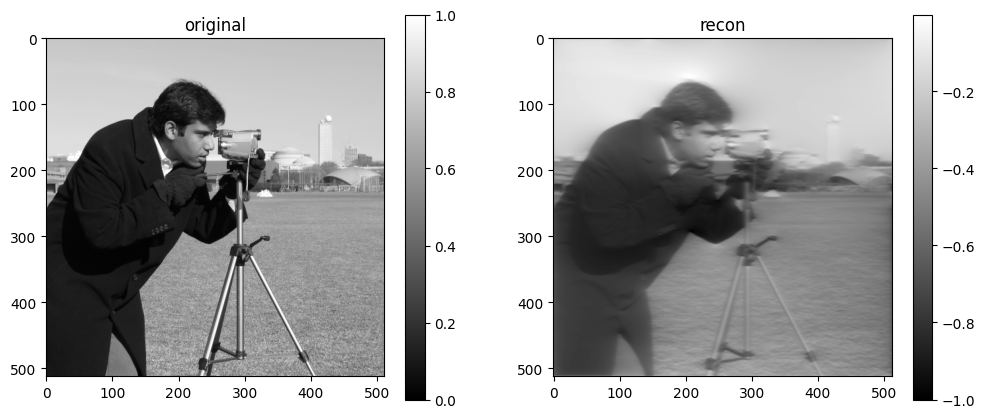

In [5]:
plt.figure( figsize=(12,5) )

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray'); plt.colorbar(); plt.title('original')
plt.subplot(1,2,2)
plt.imshow(-reconstruction, cmap='gray'); plt.colorbar(); plt.title('recon');

# Scale by scale, rather than cumulated 

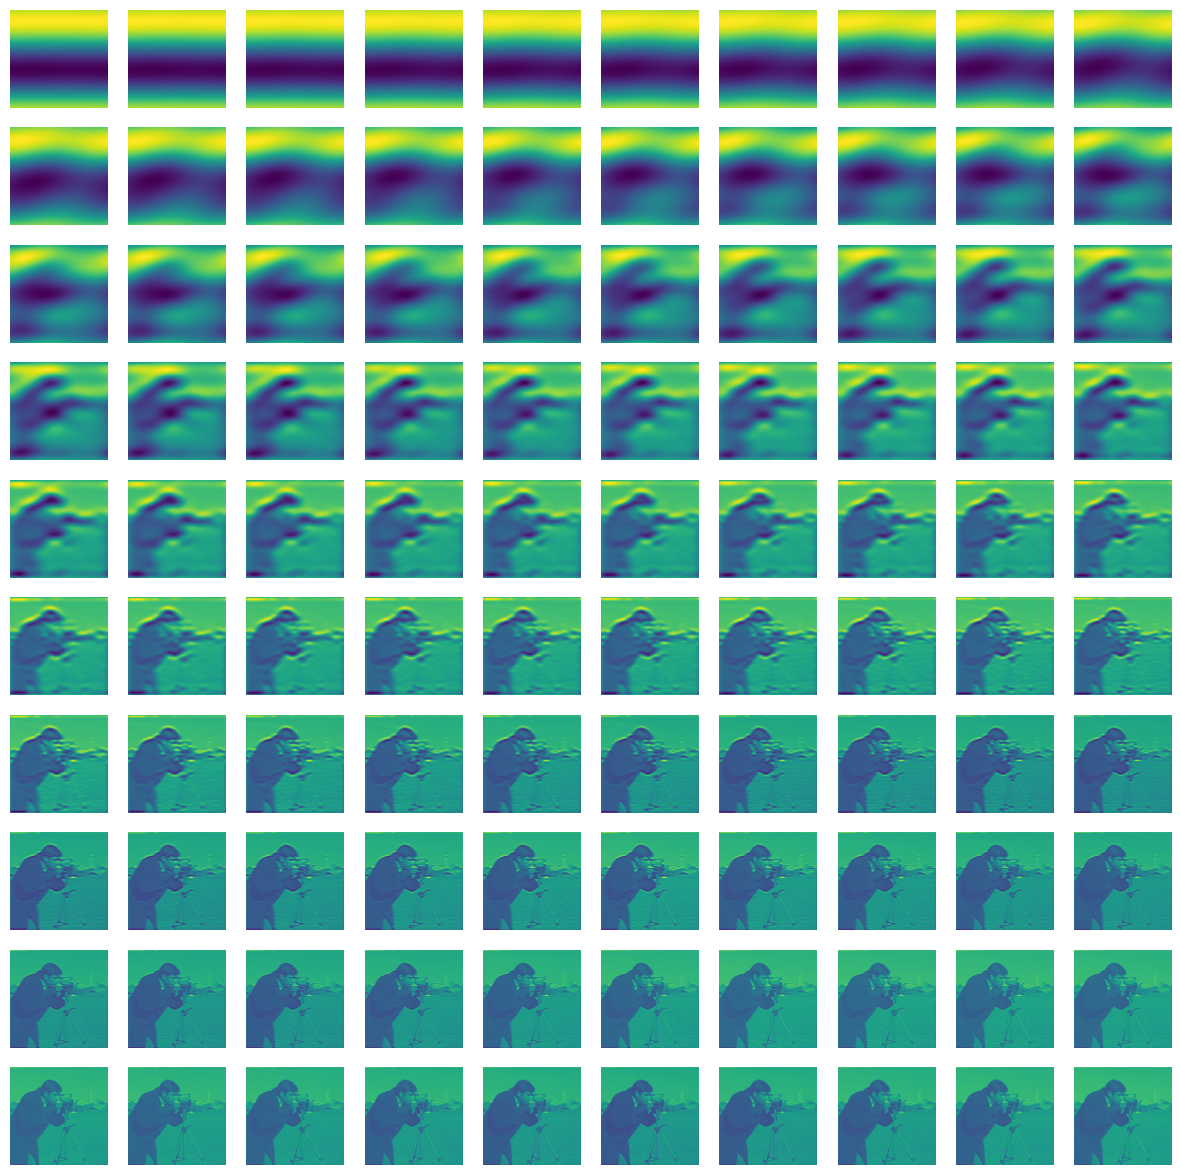

Text(0, 0.5, 'mean amplitude')

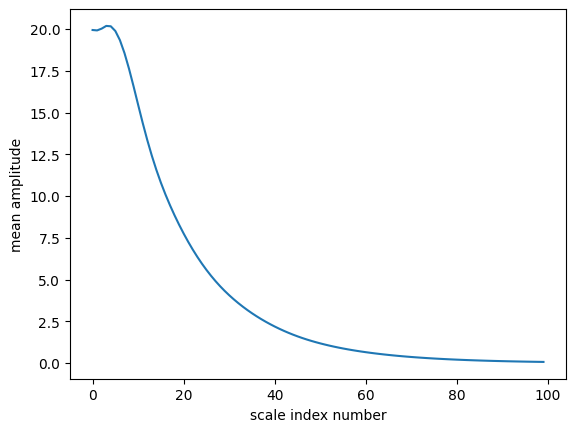

In [6]:
# Scale by scale coefficients, not cumulated, identical gray scales [-256,256]
meanamps = [] # container to hold the errors by truncation level 

fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))

for level in reversed( range(len(ss)) ):
    i = level // N
    j = level % N
    
    plt.sca(axes[N-1-i, N-1-j])
    plt.axis('off')
    plt.imshow( np.real(coeffs[:,:,level]) ) #,vmin=-256,vmax=256) #, cmap='gray')

# Measure mean amplitude at each scale (level) 
    meanamps.append(np.mean(np.abs(coeffs[:,:,level])))
    
plt.show()

# Second plot: amplitudes as a function of scale  
plt.plot(meanamps)
plt.xlabel('scale index number')
plt.ylabel('mean amplitude')

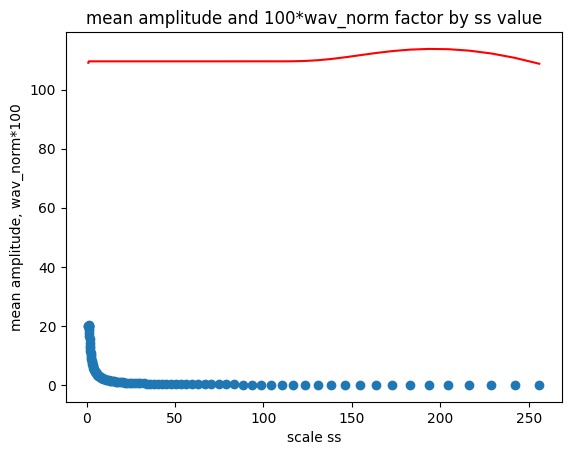

In [7]:
# plot by actual scale ss 

plt.scatter(ss, meanamps)
plt.plot(ss,wav_norm*100, 'red')

plt.xlabel('scale ss')
plt.ylabel('mean amplitude, wav_norm*100')
plt.title('mean amplitude and 100*wav_norm factor by ss value');


# Just checking: is imaginary part big? 

## Show 90th scale out of 100 (large scale structure) 

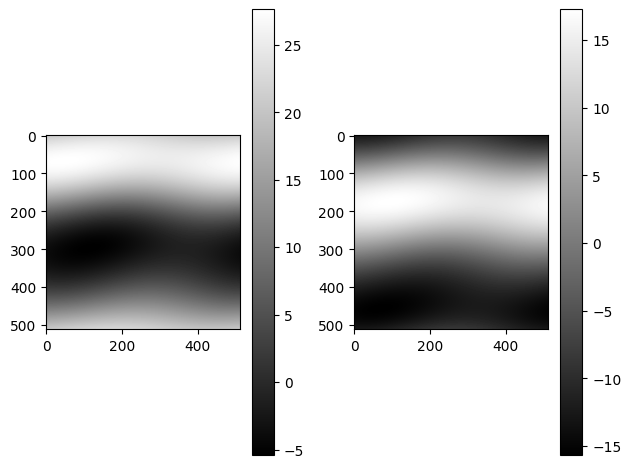

In [8]:
plt.subplot(121) 
plt.imshow( np.real(coeffs[:,:,90]), cmap='gray' ); plt.colorbar()
plt.subplot(122) 
plt.imshow( np.imag(coeffs[:,:,90]), cmap='gray' ); plt.colorbar()
plt.tight_layout()

------------------
# reconstruction code from original repo 
### https://github.com/LeonArcher/py_cwt2d

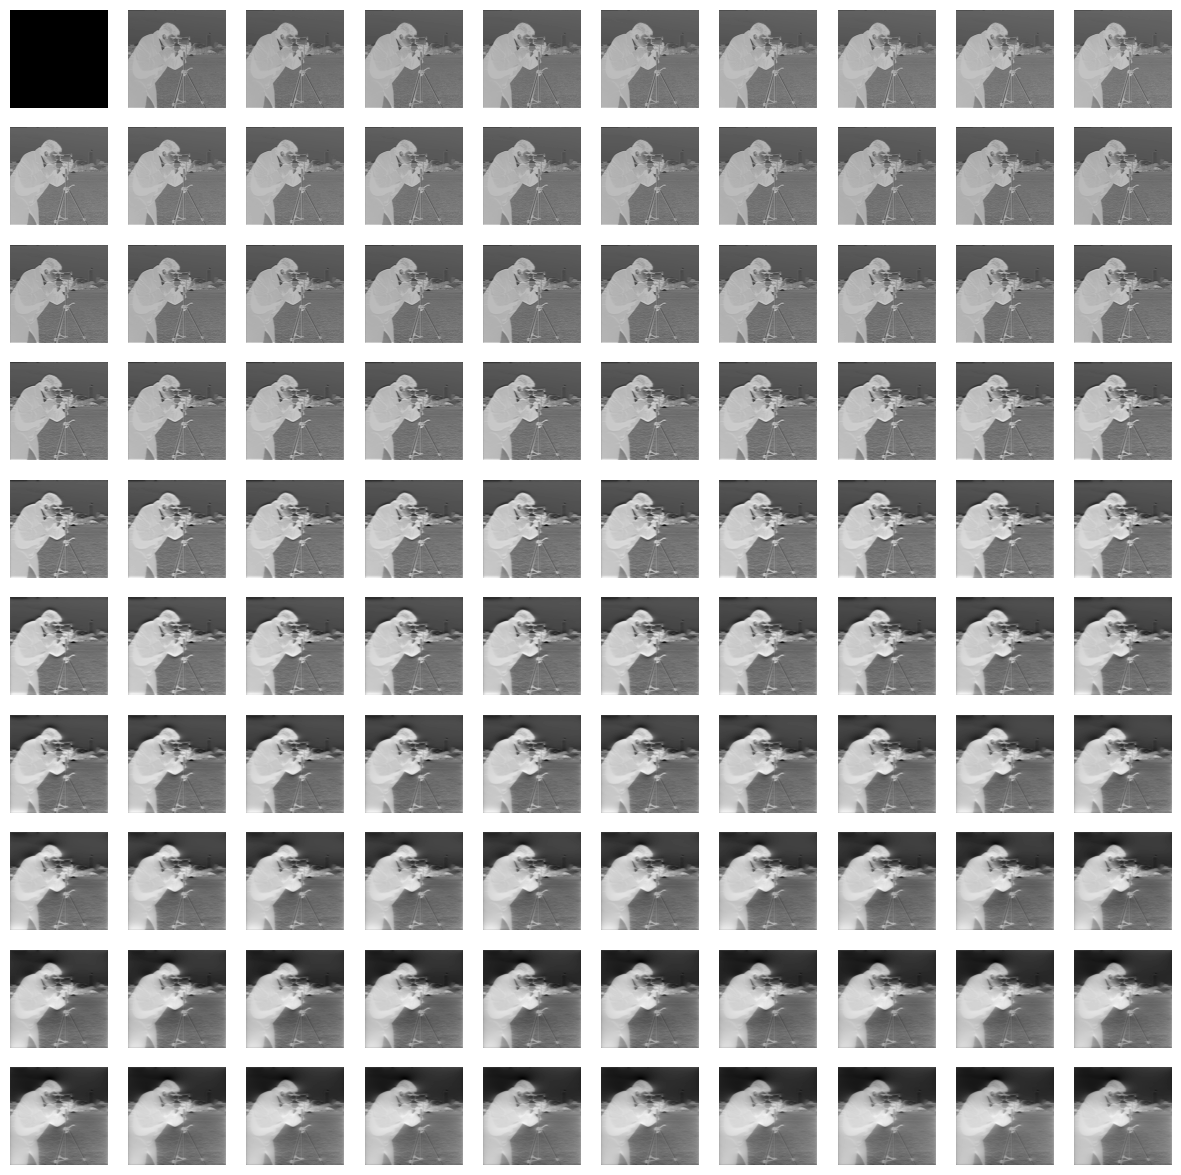

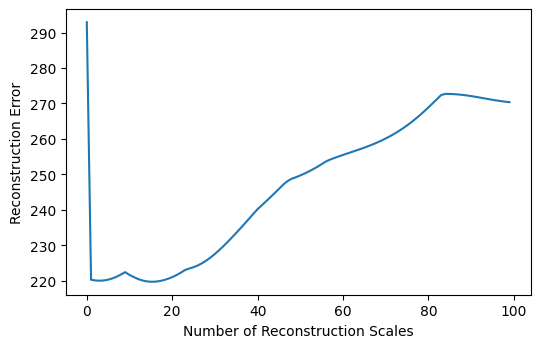

In [9]:
# from the original repo: reconstruction from small to large 

# plot an image showing the combinations of all the scales
errors = []
N = 10  # 10x10 thumbnails

# Plot a successive reconstruction, by truncation level 
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))

# Loop over truncation levels 
for level in range(len(ss)):
    i = level // N
    j = level % N
    plt.sca(axes[i, j])
    plt.axis('off')
    
#    C = 1.0 / (ss[:level] * wav_norm[:level]) # normalize each contribution     
    C = CC[:level]
    reconstruction = (C * np.real(coeffs[..., :level])).sum(axis=-1)

# rescale to [0,1] since wavelet is not orthogonal, to define error 
    reconstruction = 1.0 - (reconstruction - reconstruction.min())/ \
                     (reconstruction.max() - reconstruction.min() + 1e-9) # 1e-9 prevents /0 NAN error 
    errors.append(np.sqrt(np.sum(np.power(reconstruction - image, 2.0))))

    plt.imshow(reconstruction, cmap='gray')
    
plt.show()

fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6/1.618))
plt.plot(errors, label='norm')
plt.xlabel('Number of Reconstruction Scales')
plt.ylabel('Reconstruction Error')
plt.show()